In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
path = kagglehub.dataset_download('abhi8923shriv/sentiment-analysis-dataset')

print('Data source import complete.')


100%|███████████████████████████████████████████████████████████████████████████| 54.4M/54.4M [00:02<00:00, 21.8MB/s]

Extracting files...


Data source import complete.


# Sentiment Analysis on Kaggle sentiment analysis dataset
sentiment analysis tasks on kaggle sentiment analysis dataset using simple machine learning model: Naive bayes


## Including needed libraries

In [2]:
# --------------- MAIN LIBRARIES ------------------

import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split


# --------------- HELPING LIBRARIES ----------------
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# ------------- Pytorch Librairies ---------------
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel

## Uploading Data

In [3]:
train_dataset = path+'/train.csv'
test_dataset = path+'/test.csv'

# Check if the path exists
print (os.path.exists(train_dataset))
print (os.path.exists(test_dataset))

True
True


In [ ]:
# Load the CSV file into a DataFrame
train_df = pd.read_csv(train_dataset, encoding='ISO-8859-1')
test_df = pd.read_csv(test_dataset, encoding='ISO-8859-1')

In [6]:
train_df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


## Data Preprocessing

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27481 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27481 non-null  object 
 4   Time of Tweet     27481 non-null  object 
 5   Age of User       27481 non-null  object 
 6   Country           27481 non-null  object 
 7   Population -2020  27481 non-null  int64  
 8   Land Area (Km²)   27481 non-null  float64
 9   Density (P/Km²)   27481 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.1+ MB


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4815 entries, 0 to 4814
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            3534 non-null   object 
 1   text              3534 non-null   object 
 2   sentiment         3534 non-null   object 
 3   Time of Tweet     3534 non-null   object 
 4   Age of User       3534 non-null   object 
 5   Country           3534 non-null   object 
 6   Population -2020  3534 non-null   float64
 7   Land Area (Km²)   3534 non-null   float64
 8   Density (P/Km²)   3534 non-null   float64
dtypes: float64(3), object(6)
memory usage: 338.7+ KB


#### Handling null values

In [9]:
train_df.isnull().sum()

textID              0
text                1
selected_text       1
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

In [10]:
train_df = train_df.dropna()
train_df.isnull().sum()

textID              0
text                0
selected_text       0
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

In [11]:
test_df.isnull().sum()

textID              1281
text                1281
sentiment           1281
Time of Tweet       1281
Age of User         1281
Country             1281
Population -2020    1281
Land Area (Km²)     1281
Density (P/Km²)     1281
dtype: int64

In [12]:
test_df = test_df.dropna()
test_df.isnull().sum()

textID              0
text                0
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

#### Removing stopwords & lowercase all text

In [13]:
# Download necessary NLTK data
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/santiago/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
# Text preprocessing function that removes stopwords and convert text to lowercase

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text



In [15]:
# Apply preprocessing on train dataset
train_df['processed_text'] = train_df['text'].apply(preprocess_text)
train_df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²),processed_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60,"i`d responded, going"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105,sooo sad miss san diego!!!
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18,boss bullying me...
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164,interview! leave alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26,"sons ****, couldn`t put releases already bought"


In [16]:
# Apply preprocessing on test dataset
test_df['processed_text'] = test_df['text'].apply(preprocess_text)
test_df.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²),processed_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0,last session day http://twitpic.com/67ezh
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0,shanghai also really exciting (precisely -- sk...
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0,"recession hit veronique branquinho, quit compa..."
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0,happy bday!
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0,http://twitpic.com/4w75p - like it!!


## Check Imbalancing

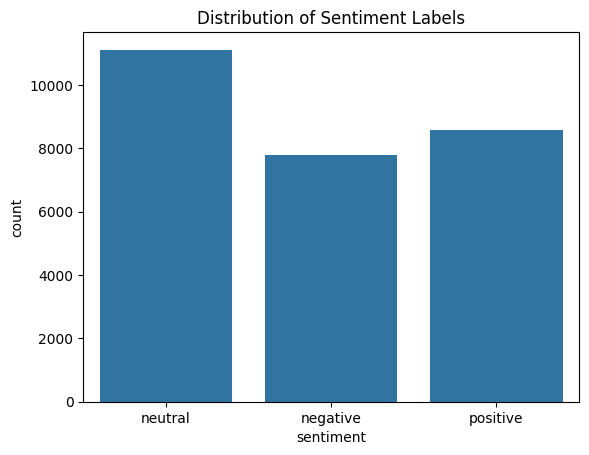

In [19]:
# Distribution of sentiment labels
sns.countplot(x='sentiment', data=train_df)
plt.title("Distribution of Sentiment Labels")
plt.show()

In [20]:
# 1. Transform sentiment into 3 classes
# Example mapping: positive -> 2, neutral -> 1, negative -> 0
sentiment_mapping = {"positive": 2, "neutral": 1, "negative": 0}
train_df["sentiment_class"] = train_df["sentiment"].map(sentiment_mapping)
test_df["sentiment_class"] = test_df["sentiment"].map(sentiment_mapping)
train_df.to_csv("train_df_processed.csv", index=False)
test_df.to_csv("test_df_processed.csv", index=False)

In [ ]:
# 2. Extract all the values from the 'processed_text' column into a list
trainval_x = train_df["processed_text"].tolist()
trainval_y = train_df["sentiment_class"].tolist()

train_x, val_x, train_y, val_y = train_test_split(trainval_x, trainval_y, test_size=0.25, random_state=42)

test_x = test_df["processed_text"].tolist()
test_y = test_df["sentiment_class"].tolist()

In [ ]:
print(len(trainval_x),len(val_x),len(test_x))

27480 6870 3534


In [ ]:
# Hyperparameters
PRETRAINED_MODEL = "bert-base-uncased"
MAX_LENGTH = 128
BATCH_SIZE = 64
NUM_CLASSES = 3
LEARNING_RATE = 2e-5
EPOCHS = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        """
        Args:
            texts (list): List of text samples.
            labels (list): List of sentiment labels (e.g., 0, 1).
            tokenizer (transformers.BertTokenizer): Tokenizer for BERT.
            max_length (int): Maximum length for tokenized sequences.
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Tokenize and encode the text
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Extract embeddings for all data
def extract_embeddings(model, dataloader, device):
    """
    Extracts embeddings for all data using a pre-trained BERT model.

    Args:
        model (transformers.BertModel): Pre-trained BERT model.
        dataloader (DataLoader): DataLoader for the dataset.
        device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
        torch.Tensor: A matrix of size (number_of_samples, embedding_size).
    """
    model.eval()  # Set the model to evaluation mode
    embeddings = []

    with torch.no_grad():  # Disable gradient computation
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            # Forward pass through BERT
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.pooler_output  # CLS token representation

            # Append embeddings to the list
            embeddings.append(pooled_output.cpu())

    # Combine all embeddings into a single matrix
    return torch.cat(embeddings, dim=0)

# Initialize tokenizer, dataset, and dataloader
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL)
traindataset = TextDataset(train_x, train_y, tokenizer, MAX_LENGTH)
trainloader = DataLoader(traindataset, batch_size=BATCH_SIZE, shuffle=False)
valdataset = TextDataset(val_x, val_y, tokenizer, MAX_LENGTH)
valloader = DataLoader(valdataset, batch_size=BATCH_SIZE, shuffle=False)

bert = BertModel.from_pretrained(PRETRAINED_MODEL).to(device)
# Extract embeddings
train_embeddings = extract_embeddings(bert, trainloader, device)
train_embeddings =train_embeddings.cpu()

val_embeddings = extract_embeddings(bert, valloader, device)
val_embeddings =val_embeddings.cpu()


In [ ]:
print(train_embeddings.size())
print(val_embeddings.size())


torch.Size([20610, 768])
torch.Size([6870, 768])


In [ ]:
criterion= nn.CrossEntropyLoss()

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# Custom Dataset
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        """
        Args:
            texts (list): List of text samples.
            labels (list): List of sentiment labels (e.g., 0, 1).
            tokenizer (transformers.BertTokenizer): Tokenizer for BERT.
            max_length (int): Maximum length for tokenized sequences.
        """
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        # Tokenize and encode the text
        embeddings = self.embeddings[idx]
        label = self.labels[idx]

        return {
            "input_ids": embeddings.squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Model Definition
class SentimentClassifier(nn.Module):
    def __init__(self, hidden_size, num_classes):
        super(SentimentClassifier, self).__init__()

        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, input_ids):

        # Pass through the fully connected layer
        logits = self.fc(input_ids)
        return logits

# training script

def train( model, train_loader, optimizer, epoch,log_interval=50):
    model.train()
    loss_cpu=0
    correct = 0
    total = 0
    for batch_idx, data in enumerate(train_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, target = data['input_ids'],data['label']
        inputs, target = inputs.cuda(), target.cuda()
        inputs =inputs.detach()



        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        loss_cpu+= loss.item()
        total += target.size(0)
        correct += predicted.eq(target.data).cpu().sum()

        if batch_idx % log_interval == 0:
            print('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                %(epoch, EPOCHS, batch_idx+1,
                    (len(train_loader)//BATCH_SIZE)+1, loss.item(), 100.*correct/total))
            #n_iter=epoch * len(train_loader) + batch_idx

    return loss_cpu/len(train_loader)

# testing script
def test( model, test_loader,epoch):
    model.eval()
    correct = 0
    total = 0
    test_loss_MSE =0
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader, 0):
            inputs, target = data['input_ids'],data['label']
            inputs, target = inputs.cuda(), target.cuda()
            outputs  = model(inputs)
            loss = criterion(outputs,target)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += predicted.eq(target.data).cpu().sum()
            test_loss_MSE+= loss.item()

    test_loss_MSE = test_loss_MSE/ len(test_loader)
    print("\n| Validation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%%" %(epoch, loss.item(), 100.*correct/total))
    return test_loss_MSE, 100.*correct/total

In [ ]:
print ("Let us Train.")
EPOCHS = 50
model = SentimentClassifier(768, NUM_CLASSES).to(device)
model_test = SentimentClassifier(768, NUM_CLASSES).to(device)
best_error = float('inf')
LEARNING_RATE = 1e-3
from torch.optim.lr_scheduler import ReduceLROnPlateau,StepLR

traindataset = EmbeddingDataset(train_embeddings, train_y)
trainloader = DataLoader(traindataset, batch_size=BATCH_SIZE, shuffle=True)
valdataset = EmbeddingDataset(val_embeddings, val_y)
valloader = DataLoader(valdataset, batch_size=BATCH_SIZE, shuffle=True)



optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
#lr_scheduler =  StepLR(optimizer, step_size=20, gamma=0.1)
lr_scheduler = ReduceLROnPlateau(optimizer, 'min', patience=7)

train_history = []
val_history = []
print('----------------------------------------------------------------------------------------------------')
print('3/ training model 1')
print('----------------------------------------------------------------------------------------------------')

iter =0
for epoch in range(EPOCHS):
    loss = train(model, trainloader, optimizer, epoch)
    train_history.append(loss)
    #lr_scheduler.step()
    val_loss= test(model, valloader,epoch)
    val_history.append(val_loss)
    lr_scheduler.step(val_loss)
    print('lr =',get_lr(optimizer))

    if val_loss <best_error:
        best_error=val_loss
        print('Best RMSE is of : ' + str(best_error), 'for epoch :', epoch,'ERROR TEST = ',val_loss)
        #model_test.parameters()=model.state_dict()
        model_test.load_state_dict(model.state_dict(), strict=True)

print ("Training Done!")

Let us Train.
----------------------------------------------------------------------------------------------------
3/ training model 1
----------------------------------------------------------------------------------------------------
| Epoch [  0/ 50] Iter[  1/  6]		Loss: 1.0910 Acc@1: 40.625%
| Epoch [  0/ 50] Iter[ 51/  6]		Loss: 1.0971 Acc@1: 40.012%
| Epoch [  0/ 50] Iter[101/  6]		Loss: 1.0606 Acc@1: 40.671%
| Epoch [  0/ 50] Iter[151/  6]		Loss: 1.0552 Acc@1: 41.505%
| Epoch [  0/ 50] Iter[201/  6]		Loss: 1.0201 Acc@1: 42.607%
| Epoch [  0/ 50] Iter[251/  6]		Loss: 0.9993 Acc@1: 43.762%
| Epoch [  0/ 50] Iter[301/  6]		Loss: 0.9892 Acc@1: 44.451%

| Validation Epoch #0			Loss: 1.0242 Acc@1: 51.72%
lr = 0.001
Best RMSE is of : 1.0183745716457013 for epoch : 0 ERROR TEST =  1.0183745716457013
| Epoch [  1/ 50] Iter[  1/  6]		Loss: 1.0173 Acc@1: 50.000%
| Epoch [  1/ 50] Iter[ 51/  6]		Loss: 0.9601 Acc@1: 50.245%
| Epoch [  1/ 50] Iter[101/  6]		Loss: 0.9958 Acc@1: 50.588%
| Epoch

## Evaluation

In [ ]:
testdataset = TextDataset(test_x,test_y, tokenizer, MAX_LENGTH)
testloader = DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)

bert = BertModel.from_pretrained(PRETRAINED_MODEL).to(device)
# Extract embeddings

test_embeddings = extract_embeddings(bert, testloader, device)
test_embeddings =test_embeddings.cpu()
print('==================== ')
print('Test set = ')
testdataset = EmbeddingDataset(test_embeddings, test_y)
testdataset = DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=True)
test_loss,accu = test(model, testdataset,epoch)
print('==================== ')

Test set = 

| Validation Epoch #49			Loss: 1.0562 Acc@1: 55.29%


## Questions

**q0/  please analyse the dataset with differents classical machine learning model**

**q1/  please perform a classification with differents classical machine learning model and analyse the performences**

**q2/  please perform a classification with a MLP?**

**q3/  please analyse all the performences and explain which is the best**

**q4/  please use an LLM compare your performences to a LLM**

**q5/  please explain why I choose a BERT embedding instead of the raw text**

**q6/  please read the BERT paper and explain the BERT architecture**

**q7/  please finetue with LORA an LLM to classify the sentiment (optional)**